# 1. Problem Definition

Use time-series forcasting to predict sales on data from Corporacion Favorita (A large Ecuadorian-based grocery retailer).
More over: The model will need to predict the unit sales for thousands of items sold across different stores.

# 2. Data

Data downloaded from: https://www.kaggle.com/c/store-sales-time-series-forecasting/data

**train.csv:**
* Time series of features store_nb, family, and onpromotion as well as target sales
    * store_nbr: identifies the store at which the products are sold
    * family: identifies the type of product sold
    * sales: gives the total sales for a product family at a particular store at a given date
    * ompromotion: gives the total number of items in a product family that were being promoted at a given data

**test.csv**
* Same features as the training data
* Dates are 15 days after the last date in the training data

**stores.csv**
* Store metadata, inlucing city, state, type, and cluster
    * cluster is a grouping of similar stores
    
**oil.csv**
* Daily oil price
    * inlcudes values during both the train and test data timeframes 

**holiday_events.csv**
* Holidays and Events with metadata
    * !!! transfered column refers to a holiday that has been transfered dates
    * if transfered is True then the holiday acts as a normal day 
    
**transactions.csv**
* Contains number of transactions for a store ID at a given date

# 3. Evaluation

The evaluation metric is Root Mean Squared Logarithmic Error (RMSLE) -> Must minimize

## Import basic libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from datetime import datetime as dt
%matplotlib inline 

## Read in data

In [2]:
# Create data frames for all csv files
# Parse dates to enrich them
train_df = pd.read_csv('data/train.csv', parse_dates=['date'])
test_df = pd.read_csv('data/test.csv', parse_dates=['date'])
stores_df = pd.read_csv('data/stores.csv')
oil_df = pd.read_csv('data/oil.csv', parse_dates=['date'])
transactions_df = pd.read_csv('data/transactions.csv', parse_dates=['date'])
holiday_df = pd.read_csv('data/holidays_events.csv', parse_dates=['date'])
# Drop un-important holiday data and ids
holiday_df.drop(['locale_name', 'description'], axis=1, inplace=True)
#train_df.drop(['id'], axis=1, inplace=True) # Will add back later for submission
#test_df.drop(['id'], axis=1, inplace=True)

### View dataframes heads

In [3]:
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0.0
4,4,2013-01-01,1,BOOKS,0.0,0.0


In [4]:
test_df.tail()

,id,date,store_nbr,family,onpromotion
28507,3029395,2017-08-31,9,POULTRY,54.0
28508,3029396,2017-08-31,9,PREPARED FOODS,10.0
28509,3029397,2017-08-31,9,PRODUCE,302.0
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,15.0
28511,3029399,2017-08-31,9,SEAFOOD,8.0


In [5]:
stores_df.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [6]:
oil_df.head(20)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
5,2013-01-08,93.21
6,2013-01-09,93.08
7,2013-01-10,93.81
8,2013-01-11,93.60
9,2013-01-14,94.27


In [7]:
transactions_df.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [8]:
holiday_df.head()

,date,type,locale,transferred
0,2012-03-02,Holiday,Local,False
1,2012-04-01,Holiday,Regional,False
2,2012-04-12,Holiday,Local,False
3,2012-04-14,Holiday,Local,False
4,2012-04-21,Holiday,Local,False


## Plot Price as a Function of Time 

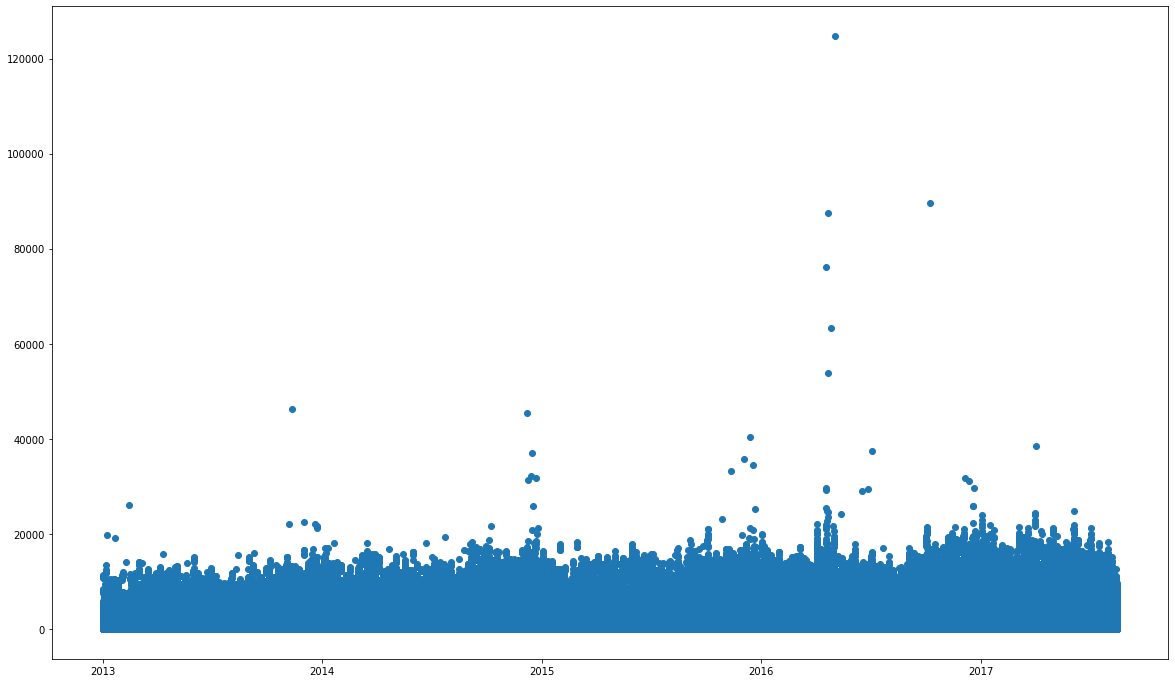

In [9]:
fig, ax = plt.subplots(figsize=(20,12))
ax.scatter(train_df['date'], train_df['sales'])

## Merge data frames for complete data sets (train and test)

In [10]:
train_df_full = train_df.merge(stores_df, how='left', on='store_nbr') 
# train_df_full = train_df_full.merge(transactions_df, how='left', on=['date', 'store_nbr'])
train_df_full = train_df_full.merge(holiday_df, how='left', on='date')
train_df_full = train_df_full.merge(oil_df, how='left', on='date')

In [11]:
test_df_full = test_df.merge(stores_df, how='left', on='store_nbr') 
# test_df_full = test_df_full.merge(transactions_df, how='left', on=['date', 'store_nbr'])
test_df_full = test_df_full.merge(holiday_df, how='left', on='date')
test_df_full = test_df_full.merge(oil_df, how='left', on='date')

In [12]:
# Rename types for clarity
train_df_full.rename(columns={'type_x':'store_type', 'type_y':'holiday_type'}, inplace=True);
test_df_full.rename(columns={'type_x':'store_type', 'type_y':'holiday_type'}, inplace=True);

In [13]:
# Make sure both data frames are ordered by date (and then store number for neatness)
# train_df_full.sort_values(by=['date', 'store_nbr'], inplace=True, ascending=True)
# test_df_full.sort_values(by=['date', 'store_nbr'], inplace=True, ascending=True)

In [14]:
train_df_full.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,holiday_type,locale,transferred,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0.0,Quito,Pichincha,D,13,Holiday,National,False,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0.0,Quito,Pichincha,D,13,Holiday,National,False,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0.0,Quito,Pichincha,D,13,Holiday,National,False,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0.0,Quito,Pichincha,D,13,Holiday,National,False,NaN
4,4,2013-01-01,1,BOOKS,0.0,0.0,Quito,Pichincha,D,13,Holiday,National,False,NaN


## Add datetime columns for

In [15]:
def add_datetime_columns(df):
    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.day
    df['dayOfWeek'] = df.date.dt.dayofweek
    df['dayOfYear'] = df.date.dt.dayofyear

In [16]:
# Add datetime features and drop original date column
add_datetime_columns(train_df_full)
add_datetime_columns(test_df_full)
train_df_full.drop('date', axis=1, inplace=True)
test_df_full.drop('date', axis=1, inplace=True)

In [17]:
train_df_full

,id,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,holiday_type,locale,transferred,dcoilwtico,year,month,day,dayOfWeek,dayOfYear
0,0,1,AUTOMOTIVE,0.000,0.0,Quito,Pichincha,D,13,Holiday,National,False,NaN,2013,1,1,1,1
1,1,1,BABY CARE,0.000,0.0,Quito,Pichincha,D,13,Holiday,National,False,NaN,2013,1,1,1,1
2,2,1,BEAUTY,0.000,0.0,Quito,Pichincha,D,13,Holiday,National,False,NaN,2013,1,1,1,1
3,3,1,BEVERAGES,0.000,0.0,Quito,Pichincha,D,13,Holiday,National,False,NaN,2013,1,1,1,1
4,4,1,BOOKS,0.000,0.0,Quito,Pichincha,D,13,Holiday,National,False,NaN,2013,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,9,POULTRY,438.133,15.0,Quito,Pichincha,B,6,Holiday,Local,False,47.57,2017,8,15,1,227
3054344,3000884,9,PREPARED FOODS,154.553,8.0,Quito,Pichincha,B,6,Holiday,Local,False,47.57,2017,8,15,1,227
3054345,3000885,9,PRODUCE,2419.729,148.0,Quito,Pichincha,B,6,Holiday,Local,False,47.57,2017,8,15,1,227
3054346,3000886,9,SCHOOL AND OFFICE SUPPLIES,121.000,10.0,Quito,Pichincha,B,6,Holiday,Local,False,47.57,2017,8,15,1,227


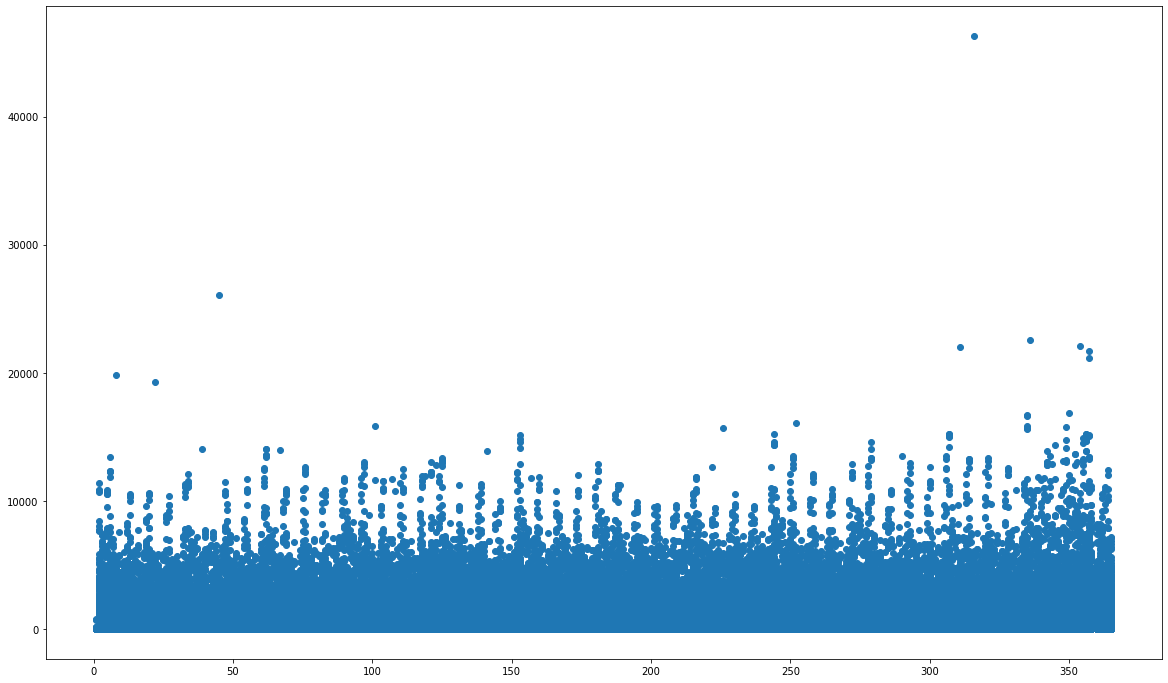

In [18]:
fig, ax = plt.subplots(figsize=(20,12))
ax.scatter(train_df_full[train_df_full.year==2013]['dayOfYear'], train_df_full[train_df_full.year==2013]['sales'])

## Clean and fill data sets

In [19]:
# Check for missing values
train_df_full.isna().sum()

id                    0
store_nbr             0
family                0
sales                 0
onpromotion           0
city                  0
state                 0
store_type            0
cluster               0
holiday_type    2551824
locale          2551824
transferred     2551824
dcoilwtico       955152
year                  0
month                 0
day                   0
dayOfWeek             0
dayOfYear             0
dtype: int64

In [20]:
# # Fill missing transactions with the median per store
# def fill_transactions(df):
#     store_list = df['store_nbr'].unique()
#     for store_number in store_list:
#         store_median = df[df['store_nbr']==store_number]['transactions'].median()
#         df.loc[(df['store_nbr']==store_number) & (df['transactions'].isna()==True), 'transactions'] = store_median

In [21]:
# fill_transactions(train_df_full)
# fill_transactions(test_df_full)

In [22]:
# Fill in or drop missing holiday types / Locale / transfers
def fill_holidays(df):
    df['holiday_type'].fillna('WorkDay', inplace=True)
    df['locale'].fillna('National', inplace=True)
    df['transferred'].fillna(False, inplace=True)

In [23]:
fill_holidays(train_df_full)
fill_holidays(test_df_full)

In [24]:
# Fill in oil prices with the average price of each year
def fill_oil_prices(df):
    year_list = df['year'].unique()
    month_list = df['month'].unique()
    for year in year_list:
        for month in month_list:
            avg_price = df[(df['year']==year) & (df['month']==month)]['dcoilwtico'].mean()
            df.loc[(df['year']==year) & (df['month']==month) & (df['dcoilwtico'].isna()==True), 'dcoilwtico'] = avg_price

In [25]:
fill_oil_prices(train_df_full)
fill_oil_prices(test_df_full)

In [26]:
# Check for missing values
train_df_full.isna().sum()

id              0
store_nbr       0
family          0
sales           0
onpromotion     0
city            0
state           0
store_type      0
cluster         0
holiday_type    0
locale          0
transferred     0
dcoilwtico      0
year            0
month           0
day             0
dayOfWeek       0
dayOfYear       0
dtype: int64

In [27]:
test_df_full.isna().sum()

id              0
store_nbr       0
family          0
onpromotion     0
city            0
state           0
store_type      0
cluster         0
holiday_type    0
locale          0
transferred     0
dcoilwtico      0
year            0
month           0
day             0
dayOfWeek       0
dayOfYear       0
dtype: int64

## Check feature importance and groupings

In [28]:
def print_categories(df):
    for label, content in df.items():
        if not pd.api.types.is_numeric_dtype(content):
            print(label)
            print(len(df[label].unique()))
            print(df[label].unique(), '\n')

In [29]:
print_categories(train_df_full)

family
33
['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD'] 

city
22
['Quito' 'Cayambe' 'Latacunga' 'Riobamba' 'Ibarra' 'Santo Domingo'
 'Guaranda' 'Puyo' 'Ambato' 'Guayaquil' 'Salinas' 'Daule' 'Babahoyo'
 'Quevedo' 'Playas' 'Libertad' 'Cuenca' 'Loja' 'Machala' 'Esmeraldas'
 'Manta' 'El Carmen'] 

state
16
['Pichincha' 'Cotopaxi' 'Chimborazo' 'Imbabura'
 'Santo Domingo de los Tsachilas' 'Bolivar' 'Pastaza' 'Tungurahua'
 'Guayas' 'Santa Elena' 'Los Rios' 'Azuay' 'Loja' 'El Oro' 'Esmeraldas'
 'Manabi'] 

store_type
5
['D' 'C' 'B' 'E' 'A'] 

holiday_type
7
['Holiday' 'WorkDay' 'Work 

In [30]:
# Get averages for each type of family
fam_averages = {}
for family in train_df_full['family'].unique():
    fam_averages[family] = (train_df_full[train_df_full['family']==family]['sales'].mean())

In [31]:
fam_averages

{'AUTOMOTIVE': 6.1195168330524226,
 'BABY CARE': 0.11160810752409352,
 'BEAUTY': 3.734268983102122,
 'BEVERAGES': 2394.9127014996325,
 'BOOKS': 0.07065992480228186,
 'BREAD/BAKERY': 464.15061157492863,
 'CELEBRATION': 8.421949954622066,
 'CLEANING': 1074.1715177838282,
 'DAIRY': 711.175990751545,
 'DELI': 265.6297463669229,
 'EGGS': 171.58472708414365,
 'FROZEN FOODS': 158.2494921881719,
 'GROCERY I': 3790.4327973335617,
 'GROCERY II': 21.662193698949824,
 'HARDWARE': 1.1395911664289726,
 'HOME AND KITCHEN I': 20.58295518388867,
 'HOME AND KITCHEN II': 16.816964864514457,
 'HOME APPLIANCES': 0.45730152556290243,
 'HOME CARE': 177.2929037555642,
 'LADIESWEAR': 7.223108172349713,
 'LAWN AND GARDEN': 6.04649077315355,
 'LINGERIE': 7.180463719261852,
 'LIQUOR,WINE,BEER': 85.75534811357448,
 'MAGAZINES': 2.9597865076278147,
 'MEATS': 341.96590481506223,
 'PERSONAL CARE': 271.1923808289036,
 'PET SUPPLIES': 3.9501166861143524,
 'PLAYERS AND ELECTRONICS': 6.234960456372359,
 'POULTRY': 351.07

C:\Users\J\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  
C:\Users\J\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


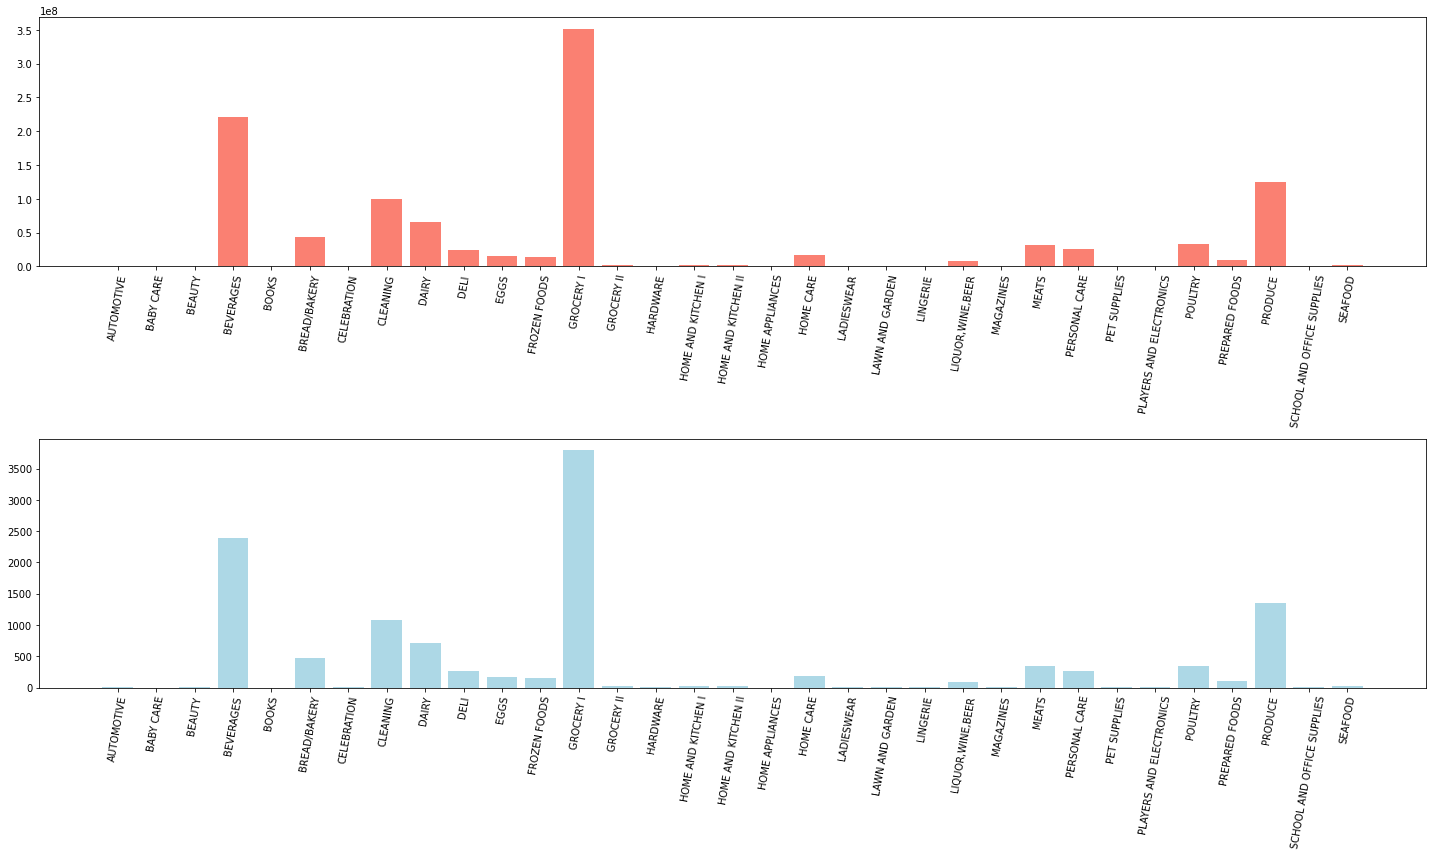

In [32]:
# Plot frequency of family types
fig, (ax1, ax2) = plt.subplots(nrows=2,
                               ncols=1,
                               figsize=(20,12))
ax1.bar(x=train_df_full['family'].unique(), height=train_df_full.groupby('family').sum()['sales'], color='salmon')
ax1.set_xticklabels(train_df_full['family'].unique(), rotation = 80);

ax2.bar(x=train_df_full['family'].unique(), height=list(fam_averages.values()), color='lightblue')
ax2.set_xticklabels(train_df_full['family'].unique(), rotation = 80);


fig.tight_layout()

## Check datatypes and encode categories

In [33]:
train_df_full.dtypes

id                int64
store_nbr         int64
family           object
sales           float64
onpromotion     float64
city             object
state            object
store_type       object
cluster           int64
holiday_type     object
locale           object
transferred        bool
dcoilwtico      float64
year              int64
month             int64
day               int64
dayOfWeek         int64
dayOfYear         int64
dtype: object

In [34]:
# Change object datatypes to numeric categories
final_train_df = train_df_full
final_test_df = test_df_full
def encode_categories(df):
    for label, content in df.items():
        if not pd.api.types.is_numeric_dtype(content):
            df[label] = pd.Categorical(content).codes+1
        if not pd.api.types.is_numeric_dtype(content):
            df[label] = pd.Categorical(content).codes+1

In [35]:
encode_categories(final_train_df)
encode_categories(final_test_df)

In [36]:
# Convert boolean columns to ints
final_train_df['transferred'] = final_train_df['transferred'].astype(int)
final_test_df['transferred'] = final_test_df['transferred'].astype(int)

In [37]:
final_train_df.dtypes

id                int64
store_nbr         int64
family             int8
sales           float64
onpromotion     float64
city               int8
state              int8
store_type         int8
cluster           int64
holiday_type       int8
locale             int8
transferred       int32
dcoilwtico      float64
year              int64
month             int64
day               int64
dayOfWeek         int64
dayOfYear         int64
dtype: object

In [38]:
final_train_df

,id,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,holiday_type,locale,transferred,dcoilwtico,year,month,day,dayOfWeek,dayOfYear
0,0,1,1,0.000,0.0,19,13,4,13,4,2,0,94.756667,2013,1,1,1,1
1,1,1,2,0.000,0.0,19,13,4,13,4,2,0,94.756667,2013,1,1,1,1
2,2,1,3,0.000,0.0,19,13,4,13,4,2,0,94.756667,2013,1,1,1,1
3,3,1,4,0.000,0.0,19,13,4,13,4,2,0,94.756667,2013,1,1,1,1
4,4,1,5,0.000,0.0,19,13,4,13,4,2,0,94.756667,2013,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,9,29,438.133,15.0,19,13,2,6,4,1,0,47.570000,2017,8,15,1,227
3054344,3000884,9,30,154.553,8.0,19,13,2,6,4,1,0,47.570000,2017,8,15,1,227
3054345,3000885,9,31,2419.729,148.0,19,13,2,6,4,1,0,47.570000,2017,8,15,1,227
3054346,3000886,9,32,121.000,10.0,19,13,2,6,4,1,0,47.570000,2017,8,15,1,227


## Build the Inital Model

In [108]:
X = final_train_df.drop('sales', axis=1)
y = final_train_df['sales']

In [109]:
# Split the training data into a test train split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

In [79]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

### GridSearch Hyper-parameters to find the most optimal model

In [82]:
%%time
rf_grid = {'n_estimators' : np.arange(10,100,10),
           'min_samples_split': np.arange(2,10,2),
           'min_samples_leaf': np.arange(1,20,2),
           'max_features': [0.5, 1, 'sqrt', 'auto'], # max_features = 1 : bad
           'max_samples': [10000]}

scaler = StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)

rf_model = GridSearchCV(RandomForestRegressor(n_jobs=-1, random_state=25),
                            param_grid=rf_grid,
                            verbose=3)

rf_model.fit(X_scaled, y_train)



Fitting 5 folds for each of 1440 candidates, totalling 7200 fits
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=10, score=0.876, total=   2.5s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=10, score=0.874, total=   1.6s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=10 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.0s remaining:    0.0s


[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=10, score=0.864, total=   0.9s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=10, score=0.844, total=   0.9s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=10, score=0.852, total=   0.8s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=20 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=20, score=0.883, total=   1.1s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=20 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_es

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=80, score=0.854, total=   2.4s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=80 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=80, score=0.872, total=   2.2s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=90 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=90, score=0.889, total=   2.4s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=90 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=90, score=0.890, total=   2.6s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=90 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_es

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=60, score=0.871, total=   1.8s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=70, score=0.888, total=   2.0s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=70, score=0.890, total=   1.9s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=70, score=0.881, total=   2.1s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_es

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_estimators=50, score=0.885, total=   1.6s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_estimators=50, score=0.886, total=   1.6s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_estimators=50, score=0.877, total=   1.6s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_estimators=50, score=0.849, total=   1.7s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_es

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=8, n_estimators=30, score=0.881, total=   1.3s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=8, n_estimators=30 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=8, n_estimators=30, score=0.875, total=   1.3s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=8, n_estimators=30 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=8, n_estimators=30, score=0.849, total=   1.2s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=8, n_estimators=30 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=8, n_estimators=30, score=0.861, total=   1.4s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=8, n_estimators=40 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=8, n_es

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=10, score=0.860, total=   0.9s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=10 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=10, score=0.837, total=   0.9s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=10 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=10, score=0.851, total=   0.8s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=20 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=20, score=0.877, total=   1.2s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=20 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_es

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=80, score=0.842, total=   2.3s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=80 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=80, score=0.860, total=   2.1s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=90 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=90, score=0.877, total=   2.4s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=90 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=90, score=0.876, total=   2.4s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=90 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_es

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=60, score=0.859, total=   1.8s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=70, score=0.878, total=   2.0s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=70, score=0.877, total=   2.1s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=70, score=0.873, total=   2.1s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_es

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=6, n_estimators=50, score=0.878, total=   1.7s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=6, n_estimators=50, score=0.876, total=   1.6s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=6, n_estimators=50, score=0.873, total=   1.7s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=6, n_estimators=50, score=0.843, total=   1.7s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=6, n_es

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=8, n_estimators=30, score=0.876, total=   1.2s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=8, n_estimators=30 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=8, n_estimators=30, score=0.871, total=   1.6s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=8, n_estimators=30 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=8, n_estimators=30, score=0.842, total=   1.3s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=8, n_estimators=30 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=8, n_estimators=30, score=0.859, total=   1.2s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=8, n_estimators=40 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=8, n_es

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=10, score=0.849, total=   0.9s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=10 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=10, score=0.821, total=   1.1s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=10 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=10, score=0.840, total=   0.8s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=20 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=20, score=0.858, total=   1.0s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=20 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_es

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=80, score=0.828, total=   2.2s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=80 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=80, score=0.847, total=   2.1s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=90 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=90, score=0.863, total=   2.3s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=90 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=90, score=0.863, total=   2.3s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=90 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_es

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=60, score=0.847, total=   1.7s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=70, score=0.864, total=   1.9s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=70, score=0.863, total=   1.9s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=70, score=0.856, total=   1.9s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_es

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=50, score=0.863, total=   1.6s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=50, score=0.863, total=   1.5s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=50, score=0.856, total=   1.5s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=50, score=0.827, total=   1.5s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_es

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=8, n_estimators=30, score=0.864, total=   1.2s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=8, n_estimators=30 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=8, n_estimators=30, score=0.856, total=   1.2s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=8, n_estimators=30 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=8, n_estimators=30, score=0.829, total=   1.2s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=8, n_estimators=30 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=8, n_estimators=30, score=0.847, total=   1.5s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=8, n_estimators=40 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=5, min_samples_split=8, n_es

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=10, score=0.836, total=   0.8s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=10 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=10, score=0.818, total=   0.9s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=10 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=10, score=0.831, total=   0.9s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=20 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=20, score=0.854, total=   1.0s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=20 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_es

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=80, score=0.817, total=   1.9s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=80 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=80, score=0.835, total=   2.1s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=90 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=90, score=0.854, total=   2.4s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=90 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=90, score=0.849, total=   2.3s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=90 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_es

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=60, score=0.835, total=   1.6s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=70, score=0.853, total=   1.9s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=70, score=0.850, total=   1.8s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=70, score=0.847, total=   1.8s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_es

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=50, score=0.854, total=   1.6s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=50, score=0.850, total=   1.6s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=50, score=0.846, total=   1.6s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=50, score=0.816, total=   1.5s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_es

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=8, n_estimators=30, score=0.851, total=   1.2s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=8, n_estimators=30 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=8, n_estimators=30, score=0.845, total=   1.2s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=8, n_estimators=30 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=8, n_estimators=30, score=0.820, total=   1.2s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=8, n_estimators=30 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=8, n_estimators=30, score=0.836, total=   1.3s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=8, n_estimators=40 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=7, min_samples_split=8, n_es

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=10, score=0.830, total=   0.8s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=10 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=10, score=0.812, total=   0.9s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=10 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=10, score=0.825, total=   0.9s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=20 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=20, score=0.845, total=   1.0s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=20 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_es

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=80, score=0.805, total=   2.0s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=80 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=80, score=0.824, total=   1.9s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=90 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=90, score=0.842, total=   2.2s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=90 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=90, score=0.838, total=   2.2s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=90 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_es

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=60, score=0.823, total=   1.6s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=70, score=0.842, total=   1.9s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=70, score=0.837, total=   1.8s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=70, score=0.832, total=   1.8s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_es

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_estimators=50, score=0.842, total=   1.5s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_estimators=50, score=0.838, total=   1.5s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_estimators=50, score=0.833, total=   1.5s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_estimators=50, score=0.806, total=   1.6s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_es

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=30, score=0.842, total=   1.1s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=30 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=30, score=0.833, total=   1.2s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=30 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=30, score=0.810, total=   1.1s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=30 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=30, score=0.826, total=   1.1s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=40 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_es

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=10, score=0.825, total=   0.9s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=10 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=10, score=0.798, total=   0.8s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=10 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=10, score=0.809, total=   0.9s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=20 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=20, score=0.834, total=   1.0s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=20 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_spli

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=80, score=0.796, total=   1.9s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=80 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=80, score=0.813, total=   2.0s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=90 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=90, score=0.830, total=   2.2s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=90 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=90, score=0.832, total=   2.2s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=90 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_spli

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=60, score=0.812, total=   1.6s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=70, score=0.831, total=   1.9s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=70, score=0.830, total=   1.6s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=70, score=0.823, total=   1.8s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_spli

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=6, n_estimators=50, score=0.832, total=   1.5s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=6, n_estimators=50, score=0.830, total=   1.6s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=6, n_estimators=50, score=0.825, total=   1.5s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=6, n_estimators=50, score=0.797, total=   1.6s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_spli

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=30, score=0.834, total=   1.2s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=30 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=30, score=0.828, total=   1.2s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=30 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=30, score=0.800, total=   1.2s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=30 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=30, score=0.814, total=   1.5s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=40 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=11, min_samples_spli

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=10, score=0.815, total=   0.9s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=10 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=10, score=0.791, total=   0.9s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=10 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=10, score=0.800, total=   0.8s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=20 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=20, score=0.819, total=   1.0s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=20 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_spli

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=80, score=0.786, total=   2.0s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=80 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=80, score=0.802, total=   1.9s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=90 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=90, score=0.823, total=   2.0s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=90 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=90, score=0.816, total=   2.0s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=90 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_spli

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=60, score=0.803, total=   1.6s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=70, score=0.820, total=   1.8s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=70, score=0.815, total=   1.8s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=70, score=0.815, total=   1.9s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_spli

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=6, n_estimators=50, score=0.820, total=   1.8s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=6, n_estimators=50, score=0.817, total=   1.5s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=6, n_estimators=50, score=0.815, total=   1.5s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=6, n_estimators=50, score=0.784, total=   1.6s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_spli

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=8, n_estimators=30, score=0.821, total=   1.1s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=8, n_estimators=30 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=8, n_estimators=30, score=0.819, total=   1.1s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=8, n_estimators=30 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=8, n_estimators=30, score=0.787, total=   1.1s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=8, n_estimators=30 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=8, n_estimators=30, score=0.803, total=   1.1s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_split=8, n_estimators=40 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=13, min_samples_spli

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=10, score=0.805, total=   1.1s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=10 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=10, score=0.783, total=   0.8s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=10 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=10, score=0.790, total=   0.8s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=20 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=20, score=0.822, total=   1.0s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=20 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_spli

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=80, score=0.778, total=   1.9s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=80 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=80, score=0.796, total=   1.9s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=90 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=90, score=0.814, total=   2.2s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=90 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=90, score=0.811, total=   2.0s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=90 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_spli

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=60, score=0.796, total=   1.6s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=70, score=0.814, total=   1.8s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=70, score=0.811, total=   1.7s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=70, score=0.806, total=   1.8s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_spli

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=6, n_estimators=50, score=0.817, total=   1.6s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=6, n_estimators=50, score=0.812, total=   1.6s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=6, n_estimators=50, score=0.806, total=   1.5s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=6, n_estimators=50, score=0.779, total=   1.5s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_spli

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=8, n_estimators=30, score=0.815, total=   1.1s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=8, n_estimators=30 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=8, n_estimators=30, score=0.809, total=   1.2s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=8, n_estimators=30 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=8, n_estimators=30, score=0.783, total=   1.2s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=8, n_estimators=30 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=8, n_estimators=30, score=0.797, total=   1.3s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_split=8, n_estimators=40 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=15, min_samples_spli

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=10, score=0.795, total=   0.8s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=10 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=10, score=0.768, total=   0.8s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=10 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=10, score=0.792, total=   0.9s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=20 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=20, score=0.809, total=   0.9s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=20 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_spli

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=80, score=0.771, total=   1.9s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=80 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=80, score=0.791, total=   2.0s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=90 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=90, score=0.806, total=   1.9s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=90 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=90, score=0.804, total=   2.1s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=90 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_spli

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=60, score=0.790, total=   1.6s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=70, score=0.804, total=   1.8s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=70, score=0.804, total=   1.6s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=70, score=0.796, total=   1.8s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_spli

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=6, n_estimators=50, score=0.806, total=   1.5s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=6, n_estimators=50, score=0.805, total=   1.6s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=6, n_estimators=50, score=0.797, total=   1.5s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=6, n_estimators=50, score=0.771, total=   1.6s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_spli

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=8, n_estimators=30, score=0.808, total=   1.2s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=8, n_estimators=30 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=8, n_estimators=30, score=0.799, total=   1.1s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=8, n_estimators=30 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=8, n_estimators=30, score=0.775, total=   1.2s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=8, n_estimators=30 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=8, n_estimators=30, score=0.795, total=   1.2s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_split=8, n_estimators=40 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=17, min_samples_spli

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=10, score=0.788, total=   0.9s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=10 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=10, score=0.759, total=   0.8s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=10 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=10, score=0.784, total=   0.8s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=20 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=20, score=0.801, total=   1.0s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=20 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_spli

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=80, score=0.762, total=   1.9s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=80 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=80, score=0.781, total=   1.9s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=90 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=90, score=0.798, total=   2.0s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=90 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=90, score=0.798, total=   2.1s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=90 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_spli

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=60, score=0.781, total=   1.5s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=70, score=0.796, total=   1.7s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=70, score=0.799, total=   1.7s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=70, score=0.790, total=   1.7s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=70 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_spli

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=6, n_estimators=50, score=0.797, total=   1.5s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=6, n_estimators=50, score=0.801, total=   1.5s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=6, n_estimators=50, score=0.792, total=   1.5s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=6, n_estimators=50, score=0.762, total=   1.6s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=6, n_estimators=50 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_spli

[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=8, n_estimators=30, score=0.804, total=   1.1s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=8, n_estimators=30 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=8, n_estimators=30, score=0.797, total=   1.2s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=8, n_estimators=30 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=8, n_estimators=30, score=0.767, total=   1.1s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=8, n_estimators=30 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=8, n_estimators=30, score=0.785, total=   1.1s
[CV] max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_split=8, n_estimators=40 
[CV]  max_features=0.5, max_samples=10000, min_samples_leaf=19, min_samples_spli

[CV]  max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=10, score=0.529, total=   0.8s
[CV] max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=10, score=0.552, total=   0.8s
[CV] max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=10 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=10, score=0.505, total=   0.8s
[CV] max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=20 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=20, score=0.615, total=   1.0s
[CV] max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=20 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=20, score

[CV]  max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=80, score=0.613, total=   2.0s
[CV] max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=90 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=90, score=0.644, total=   2.3s
[CV] max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=90 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=90, score=0.636, total=   2.2s
[CV] max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=90 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=90, score=0.612, total=   2.2s
[CV] max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=90 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=90, score

[CV]  max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=70, score=0.624, total=   1.9s
[CV] max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=70 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=70, score=0.616, total=   1.8s
[CV] max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=70 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=70, score=0.590, total=   1.7s
[CV] max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=70 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=70, score=0.611, total=   1.9s
[CV] max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=80 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=80, score

[CV]  max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_estimators=50, score=0.589, total=   1.4s
[CV] max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_estimators=50 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_estimators=50, score=0.600, total=   1.6s
[CV] max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_estimators=60 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_estimators=60, score=0.647, total=   1.6s
[CV] max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_estimators=60 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_estimators=60, score=0.626, total=   1.6s
[CV] max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_estimators=60 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_estimators=60, score

[CV]  max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=8, n_estimators=40, score=0.599, total=   1.2s
[CV] max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=8, n_estimators=40 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=8, n_estimators=40, score=0.602, total=   1.3s
[CV] max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=8, n_estimators=40 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=8, n_estimators=40, score=0.599, total=   1.3s
[CV] max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=8, n_estimators=40 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=8, n_estimators=40, score=0.564, total=   1.3s
[CV] max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=8, n_estimators=40 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=1, min_samples_split=8, n_estimators=40, score

[CV]  max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=20, score=0.534, total=   1.0s
[CV] max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=20 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=20, score=0.556, total=   1.2s
[CV] max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=20 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=20, score=0.541, total=   1.1s
[CV] max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=30 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=30, score=0.552, total=   1.1s
[CV] max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=30 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=30, score

[CV]  max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=90, score=0.551, total=   2.0s
[CV] max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=10 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=10, score=0.494, total=   0.8s
[CV] max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=10 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=10, score=0.503, total=   0.7s
[CV] max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=10 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=10, score=0.489, total=   0.9s
[CV] max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=10 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=10, score

[CV]  max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=80, score=0.587, total=   1.9s
[CV] max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=80 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=80, score=0.568, total=   1.8s
[CV] max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=80 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=80, score=0.557, total=   1.8s
[CV] max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=80 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=80, score=0.551, total=   1.8s
[CV] max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=90 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score

[CV]  max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=6, n_estimators=60, score=0.557, total=   1.6s
[CV] max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=6, n_estimators=60 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=6, n_estimators=60, score=0.559, total=   1.7s
[CV] max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=6, n_estimators=70 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=6, n_estimators=70, score=0.571, total=   1.8s
[CV] max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=6, n_estimators=70 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=6, n_estimators=70, score=0.579, total=   1.8s
[CV] max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=6, n_estimators=70 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=6, n_estimators=70, score

[CV]  max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=8, n_estimators=50, score=0.542, total=   1.5s
[CV] max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=8, n_estimators=50 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=8, n_estimators=50, score=0.556, total=   1.5s
[CV] max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=8, n_estimators=50 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=8, n_estimators=50, score=0.543, total=   1.4s
[CV] max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=8, n_estimators=50 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=8, n_estimators=50, score=0.536, total=   1.3s
[CV] max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=8, n_estimators=50 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=3, min_samples_split=8, n_estimators=50, score

[CV]  max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=30, score=0.505, total=   1.2s
[CV] max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=30 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=30, score=0.525, total=   1.2s
[CV] max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=30 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=30, score=0.557, total=   1.1s
[CV] max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=40 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=40, score=0.528, total=   1.4s
[CV] max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=40 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=40, score

[CV]  max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=10, score=0.524, total=   0.8s
[CV] max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=20 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=20, score=0.508, total=   1.0s
[CV] max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=20 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=20, score=0.512, total=   1.0s
[CV] max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=20 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=20, score=0.520, total=   1.1s
[CV] max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=20 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=20, score

[CV]  max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=90, score=0.548, total=   1.9s
[CV] max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=90 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=90, score=0.528, total=   1.8s
[CV] max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=90 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=90, score=0.542, total=   2.0s
[CV] max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=90 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=90, score=0.551, total=   1.9s
[CV] max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=10 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=10, score

[CV]  max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=70, score=0.533, total=   1.7s
[CV] max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=70 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=70, score=0.547, total=   1.6s
[CV] max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=80 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=80, score=0.533, total=   1.8s
[CV] max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=80 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=80, score=0.547, total=   1.7s
[CV] max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=80 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=80, score

[CV]  max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=8, n_estimators=60, score=0.534, total=   1.5s
[CV] max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=8, n_estimators=60 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=8, n_estimators=60, score=0.542, total=   1.4s
[CV] max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=8, n_estimators=60 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=8, n_estimators=60, score=0.535, total=   1.4s
[CV] max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=8, n_estimators=60 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=8, n_estimators=60, score=0.545, total=   1.5s
[CV] max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=8, n_estimators=60 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=8, n_estimators=60, score

[CV]  max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=40, score=0.511, total=   1.3s
[CV] max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=40 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=40, score=0.487, total=   1.1s
[CV] max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=40 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=40, score=0.485, total=   1.2s
[CV] max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=50 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=50, score=0.508, total=   1.3s
[CV] max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=50 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=50, score

[CV]  max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=20, score=0.489, total=   1.0s
[CV] max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=30 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=30, score=0.485, total=   1.1s
[CV] max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=30 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=30, score=0.519, total=   1.1s
[CV] max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=30 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=30, score=0.513, total=   1.1s
[CV] max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=30 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=30, score

[CV]  max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=10, score=0.459, total=   0.9s
[CV] max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=10 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=10, score=0.418, total=   0.8s
[CV] max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=10 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=10, score=0.395, total=   0.8s
[CV] max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=10 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=10, score=0.455, total=   0.7s
[CV] max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=20 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=20, score

[CV]  max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=80, score=0.484, total=   1.6s
[CV] max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=80 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=80, score=0.498, total=   1.7s
[CV] max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=90 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=90, score=0.509, total=   1.8s
[CV] max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=90 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=90, score=0.514, total=   1.9s
[CV] max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=90 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=90, score

[CV]  max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=8, n_estimators=70, score=0.513, total=   1.7s
[CV] max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=8, n_estimators=70 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=8, n_estimators=70, score=0.505, total=   1.6s
[CV] max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=8, n_estimators=70 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=8, n_estimators=70, score=0.507, total=   1.6s
[CV] max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=8, n_estimators=70 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=8, n_estimators=70, score=0.481, total=   1.6s
[CV] max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=8, n_estimators=70 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=7, min_samples_split=8, n_estimators=70, score

[CV]  max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=50, score=0.496, total=   1.4s
[CV] max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=50 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=50, score=0.448, total=   1.3s
[CV] max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=50 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=50, score=0.468, total=   1.3s
[CV] max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=60 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=60, score=0.503, total=   1.5s
[CV] max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=60 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=60, score

[CV]  max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=30, score=0.452, total=   1.3s
[CV] max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=40 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=40, score=0.471, total=   1.2s
[CV] max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=40 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=40, score=0.484, total=   1.3s
[CV] max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=40 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=40, score=0.477, total=   1.1s
[CV] max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=40 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=40, score

[CV]  max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_estimators=20, score=0.443, total=   1.0s
[CV] max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_estimators=20 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_estimators=20, score=0.511, total=   1.0s
[CV] max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_estimators=20 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_estimators=20, score=0.432, total=   1.1s
[CV] max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_estimators=20 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_estimators=20, score=0.445, total=   0.8s
[CV] max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_estimators=30 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_estimators=30, score

[CV]  max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_estimators=90, score=0.468, total=   1.7s
[CV] max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_estimators=90 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_estimators=90, score=0.472, total=   1.7s
[CV] max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=10 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=10, score=0.429, total=   0.8s
[CV] max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=10 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=10, score=0.398, total=   0.8s
[CV] max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=10 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=10, score

[CV]  max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=80, score=0.505, total=   1.7s
[CV] max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=80 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=80, score=0.487, total=   1.6s
[CV] max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=80 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=80, score=0.505, total=   1.6s
[CV] max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=80 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=80, score=0.461, total=   1.6s
[CV] max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=80 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=80, score

[CV]  max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=60, score=0.436, total=   1.4s
[CV] max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=60 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=60, score=0.418, total=   1.5s
[CV] max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=60 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=60, score=0.468, total=   1.5s
[CV] max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=70 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=70, score=0.449, total=   1.5s
[CV] max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=70 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=

[CV]  max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=40, score=0.464, total=   1.2s
[CV] max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=50 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=50, score=0.437, total=   1.3s
[CV] max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=50 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=50, score=0.455, total=   1.2s
[CV] max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=50 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=50, score=0.424, total=   1.4s
[CV] max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=50 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=

[CV]  max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=6, n_estimators=30, score=0.444, total=   1.2s
[CV] max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=6, n_estimators=30 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=6, n_estimators=30, score=0.431, total=   1.0s
[CV] max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=6, n_estimators=30 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=6, n_estimators=30, score=0.388, total=   1.3s
[CV] max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=6, n_estimators=30 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=6, n_estimators=30, score=0.465, total=   1.1s
[CV] max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=6, n_estimators=40 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=6, n_estimators=

[CV]  max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=10, score=0.360, total=   0.8s
[CV] max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=10 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=10, score=0.421, total=   0.8s
[CV] max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=20 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=20, score=0.387, total=   0.9s
[CV] max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=20 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=20, score=0.443, total=   1.0s
[CV] max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=20 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=

[CV]  max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=90, score=0.464, total=   1.8s
[CV] max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=90 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=90, score=0.479, total=   1.7s
[CV] max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=90 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=90, score=0.441, total=   1.7s
[CV] max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=90 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=90, score=0.432, total=   1.8s
[CV] max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=90 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=

[CV]  max_features=1, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=70, score=0.464, total=   1.6s
[CV] max_features=1, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=70 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=70, score=0.428, total=   1.5s
[CV] max_features=1, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=70 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=70, score=0.418, total=   1.5s
[CV] max_features=1, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=80 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=80, score=0.467, total=   1.7s
[CV] max_features=1, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=80 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=

[CV]  max_features=1, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=50, score=0.401, total=   1.2s
[CV] max_features=1, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=60 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=60, score=0.478, total=   1.4s
[CV] max_features=1, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=60 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=60, score=0.440, total=   1.4s
[CV] max_features=1, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=60 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=60, score=0.463, total=   1.5s
[CV] max_features=1, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=60 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=

[CV]  max_features=1, max_samples=10000, min_samples_leaf=13, min_samples_split=6, n_estimators=40, score=0.416, total=   1.1s
[CV] max_features=1, max_samples=10000, min_samples_leaf=13, min_samples_split=6, n_estimators=40 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=13, min_samples_split=6, n_estimators=40, score=0.462, total=   1.1s
[CV] max_features=1, max_samples=10000, min_samples_leaf=13, min_samples_split=6, n_estimators=40 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=13, min_samples_split=6, n_estimators=40, score=0.420, total=   1.2s
[CV] max_features=1, max_samples=10000, min_samples_leaf=13, min_samples_split=6, n_estimators=40 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=13, min_samples_split=6, n_estimators=40, score=0.410, total=   1.3s
[CV] max_features=1, max_samples=10000, min_samples_leaf=13, min_samples_split=6, n_estimators=50 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=13, min_samples_split=6, n_estimators=

[CV]  max_features=1, max_samples=10000, min_samples_leaf=13, min_samples_split=8, n_estimators=20, score=0.397, total=   0.9s
[CV] max_features=1, max_samples=10000, min_samples_leaf=13, min_samples_split=8, n_estimators=20 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=13, min_samples_split=8, n_estimators=20, score=0.415, total=   0.9s
[CV] max_features=1, max_samples=10000, min_samples_leaf=13, min_samples_split=8, n_estimators=30 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=13, min_samples_split=8, n_estimators=30, score=0.476, total=   1.2s
[CV] max_features=1, max_samples=10000, min_samples_leaf=13, min_samples_split=8, n_estimators=30 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=13, min_samples_split=8, n_estimators=30, score=0.403, total=   1.1s
[CV] max_features=1, max_samples=10000, min_samples_leaf=13, min_samples_split=8, n_estimators=30 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=13, min_samples_split=8, n_estimators=

[CV]  max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=10, score=0.395, total=   0.7s
[CV] max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=10 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=10, score=0.340, total=   0.8s
[CV] max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=10 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=10, score=0.403, total=   0.7s
[CV] max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=10 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=10, score=0.342, total=   0.7s
[CV] max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=10 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=

[CV]  max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=80, score=0.420, total=   1.5s
[CV] max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=80 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=80, score=0.427, total=   1.6s
[CV] max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=80 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=80, score=0.434, total=   1.6s
[CV] max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=90 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=90, score=0.476, total=   1.8s
[CV] max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=90 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=

[CV]  max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=60, score=0.442, total=   1.4s
[CV] max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=70 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=70, score=0.478, total=   1.6s
[CV] max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=70 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=70, score=0.448, total=   1.4s
[CV] max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=70 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=70, score=0.420, total=   1.5s
[CV] max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=70 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=

[CV]  max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=6, n_estimators=50, score=0.445, total=   1.4s
[CV] max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=6, n_estimators=50 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=6, n_estimators=50, score=0.413, total=   1.2s
[CV] max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=6, n_estimators=50 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=6, n_estimators=50, score=0.409, total=   1.2s
[CV] max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=6, n_estimators=50 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=6, n_estimators=50, score=0.428, total=   1.3s
[CV] max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=6, n_estimators=60 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=6, n_estimators=

[CV]  max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=8, n_estimators=30, score=0.390, total=   1.4s
[CV] max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=8, n_estimators=30 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=8, n_estimators=30, score=0.456, total=   1.2s
[CV] max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=8, n_estimators=40 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=8, n_estimators=40, score=0.481, total=   1.2s
[CV] max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=8, n_estimators=40 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=8, n_estimators=40, score=0.460, total=   1.1s
[CV] max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=8, n_estimators=40 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=15, min_samples_split=8, n_estimators=

[CV]  max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=20, score=0.415, total=   0.8s
[CV] max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=20 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=20, score=0.394, total=   0.9s
[CV] max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=20 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=20, score=0.374, total=   0.8s
[CV] max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=20 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=20, score=0.378, total=   0.8s
[CV] max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=20 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=

[CV]  max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=90, score=0.423, total=   1.7s
[CV] max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=90 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=90, score=0.391, total=   1.7s
[CV] max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=90 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=90, score=0.422, total=   1.7s
[CV] max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=10 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=10, score=0.333, total=   0.8s
[CV] max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=10 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=

[CV]  max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=70, score=0.425, total=   1.4s
[CV] max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=80 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=80, score=0.443, total=   1.5s
[CV] max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=80 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=80, score=0.403, total=   1.6s
[CV] max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=80 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=80, score=0.415, total=   1.7s
[CV] max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=80 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=

[CV]  max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=6, n_estimators=60, score=0.400, total=   1.5s
[CV] max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=6, n_estimators=60 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=6, n_estimators=60, score=0.419, total=   1.5s
[CV] max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=6, n_estimators=60 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=6, n_estimators=60, score=0.392, total=   1.4s
[CV] max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=6, n_estimators=60 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=6, n_estimators=60, score=0.433, total=   1.3s
[CV] max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=6, n_estimators=70 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=6, n_estimators=

[CV]  max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=8, n_estimators=40, score=0.394, total=   1.1s
[CV] max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=8, n_estimators=40 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=8, n_estimators=40, score=0.430, total=   1.2s
[CV] max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=8, n_estimators=50 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=8, n_estimators=50, score=0.434, total=   1.1s
[CV] max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=8, n_estimators=50 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=8, n_estimators=50, score=0.389, total=   1.3s
[CV] max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=8, n_estimators=50 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=17, min_samples_split=8, n_estimators=

[CV]  max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=30, score=0.416, total=   1.1s
[CV] max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=30 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=30, score=0.344, total=   1.1s
[CV] max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=30 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=30, score=0.438, total=   1.2s
[CV] max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=30 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=30, score=0.418, total=   1.1s
[CV] max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=30 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=

[CV]  max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=10, score=0.388, total=   0.8s
[CV] max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=10 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=10, score=0.308, total=   0.7s
[CV] max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=10 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=10, score=0.413, total=   0.8s
[CV] max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=20 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=20, score=0.423, total=   0.9s
[CV] max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=20 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=

[CV]  max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=80, score=0.420, total=   1.5s
[CV] max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=90 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=90, score=0.424, total=   1.7s
[CV] max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=90 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=90, score=0.418, total=   1.7s
[CV] max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=90 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=90, score=0.426, total=   1.6s
[CV] max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=90 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=

[CV]  max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=6, n_estimators=70, score=0.414, total=   1.5s
[CV] max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=6, n_estimators=70 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=6, n_estimators=70, score=0.432, total=   1.6s
[CV] max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=6, n_estimators=70 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=6, n_estimators=70, score=0.421, total=   1.5s
[CV] max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=6, n_estimators=70 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=6, n_estimators=70, score=0.411, total=   1.4s
[CV] max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=6, n_estimators=80 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=6, n_estimators=

[CV]  max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=8, n_estimators=50, score=0.422, total=   1.3s
[CV] max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=8, n_estimators=50 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=8, n_estimators=50, score=0.410, total=   1.2s
[CV] max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=8, n_estimators=60 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=8, n_estimators=60, score=0.434, total=   1.4s
[CV] max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=8, n_estimators=60 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=8, n_estimators=60, score=0.433, total=   1.3s
[CV] max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=8, n_estimators=60 
[CV]  max_features=1, max_samples=10000, min_samples_leaf=19, min_samples_split=8, n_estimators=

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=30, score=0.831, total=   1.3s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=40, score=0.846, total=   1.5s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=40, score=0.846, total=   1.4s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=40, score=0.839, total=   1.4s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_spli

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=20, score=0.837, total=   1.0s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=20, score=0.847, total=   1.1s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=20, score=0.836, total=   1.2s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=20, score=0.810, total=   1.0s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_spli

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=90, score=0.850, total=   2.2s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=90 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=90, score=0.843, total=   2.1s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=90 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=90, score=0.814, total=   2.1s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=90 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=90, score=0.836, total=   2.1s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_estimators=10 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_spli

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_estimators=70, score=0.839, total=   1.8s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_estimators=70 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_estimators=70, score=0.811, total=   1.9s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_estimators=70 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_estimators=70, score=0.824, total=   1.9s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_estimators=80 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_estimators=80, score=0.848, total=   1.9s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_estimators=80 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_spli

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=8, n_estimators=50, score=0.804, total=   1.5s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=8, n_estimators=50 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=8, n_estimators=50, score=0.819, total=   1.5s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=8, n_estimators=60 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=8, n_estimators=60, score=0.843, total=   1.6s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=8, n_estimators=60 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=8, n_estimators=60, score=0.836, total=   1.6s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_split=8, n_estimators=60 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=1, min_samples_spli

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=30, score=0.801, total=   1.2s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=40, score=0.829, total=   1.4s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=40, score=0.828, total=   1.4s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=40, score=0.818, total=   1.4s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_spli

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=20, score=0.831, total=   1.1s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=20, score=0.821, total=   1.1s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=20, score=0.820, total=   1.1s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=20, score=0.799, total=   1.1s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_spli

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.830, total=   2.1s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=90 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.824, total=   2.1s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=90 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.799, total=   2.1s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=90 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.814, total=   2.1s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=6, n_estimators=10 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_spli

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=6, n_estimators=70, score=0.820, total=   1.7s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=6, n_estimators=70 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=6, n_estimators=70, score=0.798, total=   1.7s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=6, n_estimators=70 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=6, n_estimators=70, score=0.810, total=   1.7s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=6, n_estimators=80 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=6, n_estimators=80, score=0.836, total=   1.9s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=6, n_estimators=80 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_spli

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=8, n_estimators=50, score=0.788, total=   1.4s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=8, n_estimators=50 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=8, n_estimators=50, score=0.811, total=   1.4s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=8, n_estimators=60 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=8, n_estimators=60, score=0.830, total=   1.5s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=8, n_estimators=60 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=8, n_estimators=60, score=0.830, total=   1.6s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_split=8, n_estimators=60 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=3, min_samples_spli

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=30, score=0.788, total=   1.1s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=40, score=0.813, total=   1.3s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=40, score=0.803, total=   1.4s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=40, score=0.804, total=   1.4s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_spli

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=20, score=0.812, total=   1.0s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=20, score=0.810, total=   1.1s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=20, score=0.808, total=   1.0s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=20, score=0.776, total=   1.0s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_spli

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=90, score=0.812, total=   2.1s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=90 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=90, score=0.806, total=   2.0s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=90 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=90, score=0.783, total=   2.1s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=90 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=90, score=0.799, total=   2.0s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=10 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_spli

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=70, score=0.803, total=   1.8s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=70 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=70, score=0.779, total=   1.7s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=70 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=70, score=0.794, total=   1.7s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=80 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=80, score=0.817, total=   2.0s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=80 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_spli

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=8, n_estimators=50, score=0.779, total=   1.4s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=8, n_estimators=50 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=8, n_estimators=50, score=0.791, total=   1.4s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=8, n_estimators=60 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=8, n_estimators=60, score=0.816, total=   1.6s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=8, n_estimators=60 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=8, n_estimators=60, score=0.810, total=   1.5s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_split=8, n_estimators=60 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=5, min_samples_spli

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=30, score=0.771, total=   1.1s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=40, score=0.807, total=   1.4s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=40, score=0.795, total=   1.3s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=40, score=0.782, total=   1.4s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_spli

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=20, score=0.808, total=   1.0s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=20, score=0.793, total=   1.0s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=20, score=0.786, total=   1.0s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=20, score=0.768, total=   1.0s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_spli

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=90, score=0.798, total=   1.9s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=90 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=90, score=0.789, total=   2.1s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=90 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=90, score=0.765, total=   2.1s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=90 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=90, score=0.778, total=   2.0s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=10 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_spli

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=70, score=0.785, total=   1.7s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=70 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=70, score=0.761, total=   1.7s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=70 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=70, score=0.773, total=   1.8s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=80 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=80, score=0.806, total=   1.8s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=80 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_spli

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=8, n_estimators=50, score=0.760, total=   1.4s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=8, n_estimators=50 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=8, n_estimators=50, score=0.767, total=   1.4s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=8, n_estimators=60 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=8, n_estimators=60, score=0.809, total=   1.6s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=8, n_estimators=60 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=8, n_estimators=60, score=0.795, total=   1.6s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_split=8, n_estimators=60 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=7, min_samples_spli

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=30, score=0.761, total=   1.2s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=40, score=0.784, total=   1.4s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=40, score=0.772, total=   1.4s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=40, score=0.773, total=   1.4s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_spli

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=20, score=0.783, total=   1.0s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=20, score=0.766, total=   1.0s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=20, score=0.779, total=   1.0s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=20, score=0.763, total=   1.0s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_spli

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=90, score=0.778, total=   2.1s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=90 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=90, score=0.780, total=   2.0s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=90 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=90, score=0.752, total=   1.9s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=90 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=90, score=0.765, total=   1.9s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_estimators=10 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_spli

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_estimators=70, score=0.779, total=   1.7s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_estimators=70 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_estimators=70, score=0.752, total=   1.8s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_estimators=70 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_estimators=70, score=0.765, total=   1.6s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_estimators=80 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_estimators=80, score=0.786, total=   1.7s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_estimators=80 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_spli

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=50, score=0.753, total=   1.4s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=50 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=50, score=0.765, total=   1.5s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=60 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=60, score=0.787, total=   1.5s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=60 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=60, score=0.777, total=   1.5s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=60 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=9, min_samples_spli

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=30, score=0.754, total=   1.4s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=40, score=0.771, total=   1.4s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=40, score=0.768, total=   1.3s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=40, score=0.762, total=   1.3s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_sam

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=20, score=0.777, total=   1.1s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=20, score=0.778, total=   1.0s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=20, score=0.777, total=   1.1s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=20, score=0.745, total=   1.0s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_sam

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=90, score=0.773, total=   1.9s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=90 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=90, score=0.761, total=   1.9s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=90 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=90, score=0.734, total=   1.9s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=90 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=90, score=0.760, total=   2.0s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=6, n_estimators=10 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_sam

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=6, n_estimators=70, score=0.760, total=   1.6s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=6, n_estimators=70 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=6, n_estimators=70, score=0.733, total=   1.7s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=6, n_estimators=70 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=6, n_estimators=70, score=0.755, total=   1.7s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=6, n_estimators=80 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=6, n_estimators=80, score=0.773, total=   1.9s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=6, n_estimators=80 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_sam

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=50, score=0.735, total=   1.5s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=50 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=50, score=0.754, total=   1.5s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=60 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=60, score=0.772, total=   1.4s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=60 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=60, score=0.772, total=   1.4s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=60 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=11, min_sam

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=30, score=0.746, total=   1.2s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=40, score=0.763, total=   1.3s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=40, score=0.762, total=   1.2s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=40, score=0.745, total=   1.3s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_sam

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=20, score=0.762, total=   1.2s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=20, score=0.763, total=   1.0s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=20, score=0.750, total=   1.0s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=20, score=0.730, total=   1.0s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_sam

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=90, score=0.764, total=   1.8s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=90 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=90, score=0.751, total=   1.9s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=90 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=90, score=0.731, total=   2.1s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=90 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=90, score=0.750, total=   2.0s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=6, n_estimators=10 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_sam

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=6, n_estimators=70, score=0.749, total=   1.7s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=6, n_estimators=70 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=6, n_estimators=70, score=0.725, total=   1.8s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=6, n_estimators=70 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=6, n_estimators=70, score=0.746, total=   1.7s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=6, n_estimators=80 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=6, n_estimators=80, score=0.767, total=   1.7s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=6, n_estimators=80 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_sam

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=8, n_estimators=50, score=0.723, total=   1.4s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=8, n_estimators=50 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=8, n_estimators=50, score=0.747, total=   1.4s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=8, n_estimators=60 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=8, n_estimators=60, score=0.768, total=   1.5s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=8, n_estimators=60 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=8, n_estimators=60, score=0.760, total=   1.5s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_samples_split=8, n_estimators=60 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=13, min_sam

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=30, score=0.739, total=   1.1s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=40, score=0.767, total=   1.3s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=40, score=0.746, total=   1.2s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=40, score=0.745, total=   1.3s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_sam

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=20, score=0.769, total=   0.9s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=20, score=0.746, total=   0.9s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=20, score=0.743, total=   1.0s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=20, score=0.726, total=   1.1s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_sam

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=90, score=0.749, total=   1.9s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=90 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=90, score=0.742, total=   1.8s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=90 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=90, score=0.721, total=   1.9s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=90 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=90, score=0.739, total=   1.9s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=6, n_estimators=10 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_sam

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=6, n_estimators=70, score=0.742, total=   1.7s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=6, n_estimators=70 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=6, n_estimators=70, score=0.721, total=   1.7s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=6, n_estimators=70 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=6, n_estimators=70, score=0.739, total=   1.6s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=6, n_estimators=80 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=6, n_estimators=80, score=0.763, total=   1.7s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=6, n_estimators=80 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_sam

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=8, n_estimators=50, score=0.720, total=   1.4s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=8, n_estimators=50 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=8, n_estimators=50, score=0.739, total=   1.4s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=8, n_estimators=60 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=8, n_estimators=60, score=0.765, total=   1.4s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=8, n_estimators=60 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=8, n_estimators=60, score=0.749, total=   1.5s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_samples_split=8, n_estimators=60 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=15, min_sam

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=30, score=0.723, total=   1.2s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=40, score=0.743, total=   1.3s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=40, score=0.755, total=   1.2s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=40, score=0.734, total=   1.3s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_sam

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=20, score=0.745, total=   1.1s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=20, score=0.758, total=   1.1s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=20, score=0.738, total=   1.0s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=20, score=0.708, total=   1.1s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_sam

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=90, score=0.753, total=   1.8s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=90 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=90, score=0.736, total=   1.8s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=90 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=90, score=0.703, total=   1.8s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=90 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=90, score=0.733, total=   1.9s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=6, n_estimators=10 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_sam

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=6, n_estimators=70, score=0.732, total=   1.5s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=6, n_estimators=70 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=6, n_estimators=70, score=0.702, total=   1.7s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=6, n_estimators=70 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=6, n_estimators=70, score=0.728, total=   1.7s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=6, n_estimators=80 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=6, n_estimators=80, score=0.750, total=   1.7s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=6, n_estimators=80 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_sam

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=8, n_estimators=50, score=0.697, total=   1.4s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=8, n_estimators=50 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=8, n_estimators=50, score=0.729, total=   1.4s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=8, n_estimators=60 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=8, n_estimators=60, score=0.747, total=   1.5s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=8, n_estimators=60 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=8, n_estimators=60, score=0.752, total=   1.5s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_samples_split=8, n_estimators=60 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=17, min_sam

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=30, score=0.720, total=   1.1s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=40, score=0.742, total=   1.2s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=40, score=0.724, total=   1.2s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=40, score=0.722, total=   1.5s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=40 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_sam

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=20, score=0.741, total=   0.9s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=20, score=0.727, total=   1.0s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=20, score=0.730, total=   0.9s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=20, score=0.707, total=   0.9s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=20 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_sam

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=90, score=0.735, total=   1.9s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=90 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=90, score=0.733, total=   1.8s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=90 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=90, score=0.704, total=   1.9s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=90 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=90, score=0.725, total=   1.9s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=6, n_estimators=10 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_sam

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=6, n_estimators=70, score=0.729, total=   1.7s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=6, n_estimators=70 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=6, n_estimators=70, score=0.699, total=   1.5s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=6, n_estimators=70 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=6, n_estimators=70, score=0.718, total=   1.5s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=6, n_estimators=80 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=6, n_estimators=80, score=0.742, total=   1.8s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=6, n_estimators=80 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_sam

[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=8, n_estimators=50, score=0.699, total=   1.4s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=8, n_estimators=50 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=8, n_estimators=50, score=0.718, total=   1.4s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=8, n_estimators=60 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=8, n_estimators=60, score=0.742, total=   1.5s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=8, n_estimators=60 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=8, n_estimators=60, score=0.735, total=   1.4s
[CV] max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_samples_split=8, n_estimators=60 
[CV]  max_features=sqrt, max_samples=10000, min_samples_leaf=19, min_sam

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=30, score=0.872, total=   1.4s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=40, score=0.894, total=   1.8s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=40, score=0.894, total=   1.7s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=40, score=0.889, total=   1.8s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_spli

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=20, score=0.887, total=   1.3s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=20, score=0.887, total=   1.2s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=20, score=0.884, total=   1.3s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=20, score=0.856, total=   1.3s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_spli

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=90, score=0.895, total=   2.7s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=90 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=90, score=0.890, total=   2.6s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=90 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=90, score=0.860, total=   2.6s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=90 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=4, n_estimators=90, score=0.877, total=   2.6s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_estimators=10 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_spli

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_estimators=70, score=0.888, total=   2.2s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_estimators=70 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_estimators=70, score=0.857, total=   2.2s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_estimators=70 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_estimators=70, score=0.874, total=   2.3s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_estimators=80 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_estimators=80, score=0.892, total=   2.4s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=6, n_estimators=80 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_spli

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=8, n_estimators=50, score=0.854, total=   1.9s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=8, n_estimators=50 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=8, n_estimators=50, score=0.871, total=   1.8s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=8, n_estimators=60 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=8, n_estimators=60, score=0.889, total=   1.9s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=8, n_estimators=60 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=8, n_estimators=60, score=0.890, total=   1.9s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_split=8, n_estimators=60 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=1, min_samples_spli

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=30, score=0.867, total=   1.3s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=40, score=0.888, total=   1.7s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=40, score=0.886, total=   1.6s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=40, score=0.881, total=   1.6s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_spli

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=20, score=0.885, total=   1.1s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=20, score=0.882, total=   1.1s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=20, score=0.878, total=   1.1s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=20, score=0.853, total=   1.1s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_spli

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.888, total=   2.5s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=90 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.882, total=   2.5s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=90 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.853, total=   2.6s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=90 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=4, n_estimators=90, score=0.871, total=   2.6s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=6, n_estimators=10 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_spli

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=6, n_estimators=70, score=0.883, total=   2.2s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=6, n_estimators=70 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=6, n_estimators=70, score=0.853, total=   2.2s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=6, n_estimators=70 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=6, n_estimators=70, score=0.870, total=   2.2s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=6, n_estimators=80 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=6, n_estimators=80, score=0.888, total=   2.3s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=6, n_estimators=80 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_spli

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=8, n_estimators=50, score=0.851, total=   1.7s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=8, n_estimators=50 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=8, n_estimators=50, score=0.867, total=   1.8s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=8, n_estimators=60 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=8, n_estimators=60, score=0.887, total=   1.8s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=8, n_estimators=60 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=8, n_estimators=60, score=0.886, total=   1.8s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_split=8, n_estimators=60 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=3, min_samples_spli

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=30, score=0.857, total=   1.4s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=40, score=0.877, total=   1.5s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=40, score=0.875, total=   1.6s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=40, score=0.870, total=   1.4s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_spli

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=20, score=0.874, total=   1.1s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=20, score=0.872, total=   1.1s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=20, score=0.869, total=   1.3s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=20, score=0.843, total=   1.2s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_spli

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=90, score=0.877, total=   2.5s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=90 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=90, score=0.871, total=   2.5s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=90 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=90, score=0.843, total=   2.6s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=90 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=4, n_estimators=90, score=0.859, total=   2.6s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=10 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_spli

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=70, score=0.872, total=   2.1s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=70 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=70, score=0.842, total=   2.1s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=70 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=70, score=0.858, total=   2.1s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=80 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=80, score=0.877, total=   2.3s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=80 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_spli

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=8, n_estimators=50, score=0.842, total=   1.8s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=8, n_estimators=50 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=8, n_estimators=50, score=0.858, total=   1.7s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=8, n_estimators=60 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=8, n_estimators=60, score=0.878, total=   1.9s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=8, n_estimators=60 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=8, n_estimators=60, score=0.877, total=   1.8s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_split=8, n_estimators=60 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=5, min_samples_spli

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=30, score=0.846, total=   1.3s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=40, score=0.866, total=   1.5s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=40, score=0.863, total=   1.4s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=40, score=0.859, total=   1.4s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_spli

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=20, score=0.864, total=   1.0s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=20, score=0.860, total=   1.1s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=20, score=0.857, total=   1.0s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=20, score=0.833, total=   1.2s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_spli

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=90, score=0.865, total=   2.4s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=90 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=90, score=0.860, total=   2.3s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=90 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=90, score=0.832, total=   2.3s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=90 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=4, n_estimators=90, score=0.848, total=   2.4s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=10 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_spli

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=70, score=0.861, total=   2.2s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=70 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=70, score=0.831, total=   1.9s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=70 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=70, score=0.847, total=   2.2s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=80 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=80, score=0.866, total=   2.2s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=6, n_estimators=80 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_spli

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=8, n_estimators=50, score=0.832, total=   1.7s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=8, n_estimators=50 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=8, n_estimators=50, score=0.847, total=   1.7s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=8, n_estimators=60 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=8, n_estimators=60, score=0.867, total=   1.8s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=8, n_estimators=60 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=8, n_estimators=60, score=0.865, total=   1.8s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_split=8, n_estimators=60 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=7, min_samples_spli

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=30, score=0.836, total=   1.3s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=40, score=0.855, total=   1.4s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=40, score=0.854, total=   1.4s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=40, score=0.848, total=   1.4s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_spli

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=20, score=0.853, total=   1.1s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=20, score=0.850, total=   1.1s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=20, score=0.848, total=   1.1s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=20, score=0.822, total=   1.3s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_spli

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=90, score=0.856, total=   2.4s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=90 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=90, score=0.850, total=   2.3s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=90 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=90, score=0.821, total=   2.4s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=90 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=4, n_estimators=90, score=0.838, total=   2.5s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_estimators=10 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_spli

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_estimators=70, score=0.850, total=   1.9s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_estimators=70 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_estimators=70, score=0.821, total=   1.9s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_estimators=70 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_estimators=70, score=0.837, total=   1.9s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_estimators=80 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_estimators=80, score=0.856, total=   2.3s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=6, n_estimators=80 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_spli

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=50, score=0.822, total=   1.7s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=50 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=50, score=0.837, total=   1.7s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=60 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=60, score=0.856, total=   1.9s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=60 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=60, score=0.856, total=   1.8s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_split=8, n_estimators=60 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=9, min_samples_spli

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=30, score=0.826, total=   1.4s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=40, score=0.847, total=   1.4s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=40, score=0.845, total=   1.5s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=40, score=0.841, total=   1.4s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=11, min_sam

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=20, score=0.844, total=   1.1s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=20, score=0.840, total=   1.1s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=20, score=0.841, total=   1.0s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=20, score=0.813, total=   1.0s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=11, min_sam

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=90, score=0.846, total=   2.3s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=90 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=90, score=0.841, total=   2.4s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=90 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=90, score=0.812, total=   2.4s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=90 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=4, n_estimators=90, score=0.830, total=   2.4s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=6, n_estimators=10 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=11, min_sam

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=6, n_estimators=70, score=0.841, total=   2.0s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=6, n_estimators=70 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=6, n_estimators=70, score=0.812, total=   1.9s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=6, n_estimators=70 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=6, n_estimators=70, score=0.828, total=   2.0s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=6, n_estimators=80 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=6, n_estimators=80, score=0.848, total=   2.2s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=6, n_estimators=80 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=11, min_sam

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=50, score=0.812, total=   1.6s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=50 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=50, score=0.828, total=   1.7s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=60 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=60, score=0.848, total=   1.8s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=60 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=60, score=0.846, total=   1.8s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=11, min_samples_split=8, n_estimators=60 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=11, min_sam

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=30, score=0.819, total=   1.3s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=40, score=0.839, total=   1.4s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=40, score=0.835, total=   1.4s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=40, score=0.830, total=   1.4s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=13, min_sam

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=20, score=0.837, total=   1.0s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=20, score=0.830, total=   1.0s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=20, score=0.829, total=   1.0s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=20, score=0.805, total=   1.0s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=13, min_sam

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=90, score=0.837, total=   2.3s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=90 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=90, score=0.831, total=   2.4s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=90 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=90, score=0.805, total=   2.4s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=90 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=4, n_estimators=90, score=0.822, total=   2.4s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=6, n_estimators=10 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=13, min_sam

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=6, n_estimators=70, score=0.831, total=   2.0s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=6, n_estimators=70 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=6, n_estimators=70, score=0.805, total=   1.9s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=6, n_estimators=70 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=6, n_estimators=70, score=0.820, total=   2.0s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=6, n_estimators=80 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=6, n_estimators=80, score=0.839, total=   2.1s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=6, n_estimators=80 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=13, min_sam

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=8, n_estimators=50, score=0.805, total=   1.5s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=8, n_estimators=50 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=8, n_estimators=50, score=0.820, total=   1.7s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=8, n_estimators=60 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=8, n_estimators=60, score=0.840, total=   1.8s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=8, n_estimators=60 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=8, n_estimators=60, score=0.837, total=   1.8s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=13, min_samples_split=8, n_estimators=60 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=13, min_sam

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=30, score=0.812, total=   1.4s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=40, score=0.833, total=   1.4s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=40, score=0.827, total=   1.4s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=40, score=0.822, total=   1.5s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=15, min_sam

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=20, score=0.831, total=   1.1s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=20, score=0.823, total=   1.1s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=20, score=0.822, total=   1.1s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=20, score=0.797, total=   1.1s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=15, min_sam

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=90, score=0.830, total=   2.3s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=90 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=90, score=0.823, total=   2.3s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=90 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=90, score=0.796, total=   2.3s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=90 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=4, n_estimators=90, score=0.813, total=   2.4s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=6, n_estimators=10 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=15, min_sam

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=6, n_estimators=70, score=0.823, total=   1.9s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=6, n_estimators=70 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=6, n_estimators=70, score=0.796, total=   1.9s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=6, n_estimators=70 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=6, n_estimators=70, score=0.812, total=   1.9s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=6, n_estimators=80 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=6, n_estimators=80, score=0.832, total=   2.1s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=6, n_estimators=80 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=15, min_sam

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=8, n_estimators=50, score=0.796, total=   1.7s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=8, n_estimators=50 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=8, n_estimators=50, score=0.812, total=   1.8s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=8, n_estimators=60 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=8, n_estimators=60, score=0.832, total=   1.8s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=8, n_estimators=60 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=8, n_estimators=60, score=0.830, total=   1.8s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=15, min_samples_split=8, n_estimators=60 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=15, min_sam

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=30, score=0.805, total=   1.4s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=40, score=0.824, total=   1.5s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=40, score=0.821, total=   1.4s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=40, score=0.814, total=   1.5s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=17, min_sam

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=20, score=0.822, total=   1.0s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=20, score=0.816, total=   1.1s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=20, score=0.814, total=   1.1s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=20, score=0.791, total=   1.0s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=17, min_sam

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=90, score=0.823, total=   2.3s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=90 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=90, score=0.814, total=   2.2s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=90 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=90, score=0.790, total=   2.3s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=90 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=4, n_estimators=90, score=0.807, total=   2.4s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=6, n_estimators=10 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=17, min_sam

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=6, n_estimators=70, score=0.815, total=   2.0s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=6, n_estimators=70 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=6, n_estimators=70, score=0.790, total=   2.0s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=6, n_estimators=70 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=6, n_estimators=70, score=0.805, total=   1.9s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=6, n_estimators=80 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=6, n_estimators=80, score=0.823, total=   2.1s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=6, n_estimators=80 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=17, min_sam

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=8, n_estimators=50, score=0.790, total=   1.6s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=8, n_estimators=50 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=8, n_estimators=50, score=0.805, total=   1.5s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=8, n_estimators=60 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=8, n_estimators=60, score=0.824, total=   1.7s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=8, n_estimators=60 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=8, n_estimators=60, score=0.823, total=   1.8s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=17, min_samples_split=8, n_estimators=60 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=17, min_sam

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=30, score=0.800, total=   1.4s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=40, score=0.818, total=   1.4s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=40, score=0.815, total=   1.5s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=40, score=0.808, total=   1.4s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=2, n_estimators=40 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=19, min_sam

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=20, score=0.816, total=   1.0s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=20, score=0.811, total=   1.1s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=20, score=0.806, total=   1.0s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=20, score=0.785, total=   1.0s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=20 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=19, min_sam

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=90, score=0.816, total=   2.4s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=90 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=90, score=0.808, total=   2.3s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=90 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=90, score=0.784, total=   2.3s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=90 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=4, n_estimators=90, score=0.801, total=   2.3s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=6, n_estimators=10 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=19, min_sam

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=6, n_estimators=70, score=0.809, total=   2.0s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=6, n_estimators=70 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=6, n_estimators=70, score=0.784, total=   2.0s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=6, n_estimators=70 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=6, n_estimators=70, score=0.799, total=   2.0s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=6, n_estimators=80 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=6, n_estimators=80, score=0.818, total=   2.0s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=6, n_estimators=80 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=19, min_sam

[CV]  max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=8, n_estimators=50, score=0.784, total=   1.6s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=8, n_estimators=50 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=8, n_estimators=50, score=0.799, total=   1.5s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=8, n_estimators=60 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=8, n_estimators=60, score=0.818, total=   1.8s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=8, n_estimators=60 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=8, n_estimators=60, score=0.816, total=   1.8s
[CV] max_features=auto, max_samples=10000, min_samples_leaf=19, min_samples_split=8, n_estimators=60 
[CV]  max_features=auto, max_samples=10000, min_samples_leaf=19, min_sam

[Parallel(n_jobs=1)]: Done 7200 out of 7200 | elapsed: 181.4min finished


Wall time: 3h 1min 26s


GridSearchCV(estimator=RandomForestRegressor(n_jobs=-1, random_state=25),
             param_grid={'max_features': [0.5, 1, 'sqrt', 'auto'],
                         'max_samples': [10000],
                         'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                         'min_samples_split': array([2, 4, 6, 8]),
                         'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
             verbose=3)

In [85]:
rf_model.best_params_, rf_model.best_score_

({'max_features': 'auto',
  'max_samples': 10000,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 90},
 0.8840988115425636)

## Train model with best params

In [110]:
ideal_rf_model = RandomForestRegressor(max_features='auto', 
                                       max_samples=10000, 
                                       min_samples_leaf=1, 
                                       min_samples_split=2, 
                                       n_estimators=20)
ideal_rf_model.fit(X_scaled, y_train)

RandomForestRegressor(max_samples=10000, n_estimators=20)

In [111]:
X_test_scaled = scaler.transform(X_test)

In [112]:
y_preds = ideal_rf_model.predict(X_test_scaled)

In [113]:
# Compare predictions with tests
preds_df = pd.DataFrame({'preds':y_preds, 'y_tests':y_test, 'abs_diff':abs(y_test-y_preds)})
preds_df.head(50)

,preds,y_tests,abs_diff
668753,426.900000,471.000,44.100000
1267004,15.400000,1.000,14.400000
997442,0.000000,0.000,0.000000
873596,0.000000,0.000,0.000000
756145,1.900000,0.000,1.900000
703557,732.484945,7866.909,7134.424055
1247050,70.897000,107.000,36.103000
426324,0.100000,0.000,0.100000
1702905,8.550000,11.000,2.450000
313127,0.000000,0.000,0.000000


## Train the full set of train data

In [114]:
X_train = final_train_df.drop('sales', axis=1)
y_train = final_train_df['sales']
X_test = final_test_df

In [115]:
scaler = StandardScaler().fit(X_train)
train_scaled = scaler.transform(X_train)
test_scaled = scaler.transform(X_test)

In [116]:
# Re-fit model with full training set
ideal_rf_model.fit(train_scaled, y_train)

RandomForestRegressor(max_samples=10000, n_estimators=20)

In [117]:
final_preds = ideal_rf_model.predict(test_scaled)

In [103]:
final_indexes = test_df['id']
final_indexes

0        3000888
1        3000889
2        3000890
3        3000891
4        3000892
          ...   
28507    3029395
28508    3029396
28509    3029397
28510    3029398
28511    3029399
Name: id, Length: 28512, dtype: int64

In [119]:
submission_df = pd.DataFrame({'id':final_indexes, 'sales':final_preds})

In [120]:
submission_df

,id,sales
0,3000888,136.316650
1,3000889,1.950000
2,3000890,18.950000
3,3000891,4863.058650
4,3000892,1.950000
...,...,...
28507,3029395,561.142200
28508,3029396,139.181700
28509,3029397,5053.998275
28510,3029398,329.331000


In [121]:
submission_df.to_csv('submissions/sub3.csv', index=False)

In [122]:
submission_df.count

<bound method DataFrame.count of             id        sales
0      3000888   136.316650
1      3000889     1.950000
2      3000890    18.950000
3      3000891  4863.058650
4      3000892     1.950000
...        ...          ...
28507  3029395   561.142200
28508  3029396   139.181700
28509  3029397  5053.998275
28510  3029398   329.331000
28511  3029399   123.647450

[28512 rows x 2 columns]>

In [127]:
X_test

,id,store_nbr,family,onpromotion,city,state,store_type,cluster,holiday_type,locale,transferred,dcoilwtico,year,month,day,dayOfWeek,dayOfYear
0,3000888,1,1,20.0,19,13,4,13,2,2,0,46.80,2017,8,16,2,228
1,3000889,1,2,1.0,19,13,4,13,2,2,0,46.80,2017,8,16,2,228
2,3000890,1,3,8.0,19,13,4,13,2,2,0,46.80,2017,8,16,2,228
3,3000891,1,4,560.0,19,13,4,13,2,2,0,46.80,2017,8,16,2,228
4,3000892,1,5,1.0,19,13,4,13,2,2,0,46.80,2017,8,16,2,228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,3029395,9,29,54.0,19,13,2,6,2,2,0,47.26,2017,8,31,3,243
28508,3029396,9,30,10.0,19,13,2,6,2,2,0,47.26,2017,8,31,3,243
28509,3029397,9,31,302.0,19,13,2,6,2,2,0,47.26,2017,8,31,3,243
28510,3029398,9,32,15.0,19,13,2,6,2,2,0,47.26,2017,8,31,3,243
